In [21]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import numpy
import torch.utils.data
from sklearn.model_selection import train_test_split

# Display Dataset

In [22]:
import sys
sys.path.append('..')

from Datasets.MackeyGlassDataset import MackeyGlassDataset
Mglass1 = MackeyGlassDataset(1000, 5, tau=17, seed=0)
Mglass2 = MackeyGlassDataset(10000, 2, tau=20, seed=0)

([<matplotlib.lines.Line2D at 0x70c0a5503750>], (4995, 1))

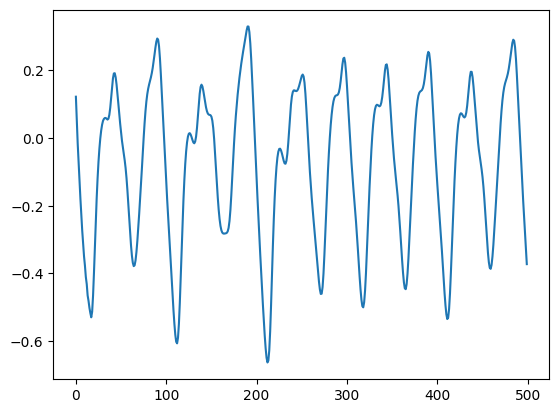

In [23]:
dataset = torch.utils.data.DataLoader(Mglass1, batch_size=1, shuffle=False)
dataset = np.array([data[0] for data in dataset]).reshape(-1, 1)
# loop through the input data (data[0]) and convert it to numpy array with shape of colomn vector

plt.plot(dataset[:500]), dataset.shape

### Splits of dataset

In [24]:
train_test_ratio = 0.8
train_size = int(len(dataset) * train_test_ratio)
test_size = len(dataset) - train_size

train_data, test_data = train_test_split(dataset, train_size=train_size, test_size=test_size)

train_data.shape, test_data.shape

((3996, 1), (999, 1))

In [25]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU is available')
else:
    device = torch.device('cpu')
    print('CPU is available')


CPU is available


In [26]:
#train_data = torch.tensor(np.array([data[0] for data in train_dataset]).reshape(-1, 1)).to(device)
#test_data = torch.tensor(np.array([data[0] for data in test_dataset]).reshape(-1, 1)).to(device)
#train_data

# ESN 

In [27]:
from Models.Echostate import ESN

esn = ESN(input_dim = 1, reservoir_dim = 200, output_dim = 1)
esn_prime = ESN(input_dim = 1, reservoir_dim = 200, output_dim = 1) 

esn.to(device)
esn.freeze_reservoir()  # Freeze reservoir weights

esn_prime.to(device)
esn_prime.freeze_reservoir()  # Freeze reservoir weights

# Define optimizer and criterion for the readout layer
#optimizer = torch.optim.Adam(esn.readout.parameters(), lr=0.05)
criterion = nn.MSELoss()
type(esn.readout)

torch.nn.modules.linear.Linear

In [28]:
inputs, targets = Mglass1[0]

inputs = inputs.to(device) 
targets = targets.to(device)

for name, param in esn.named_parameters():
    print(f"{name} is on {param.device}")

print(inputs.device, targets.device)


readout.weight is on cpu
readout.bias is on cpu
cpu cpu


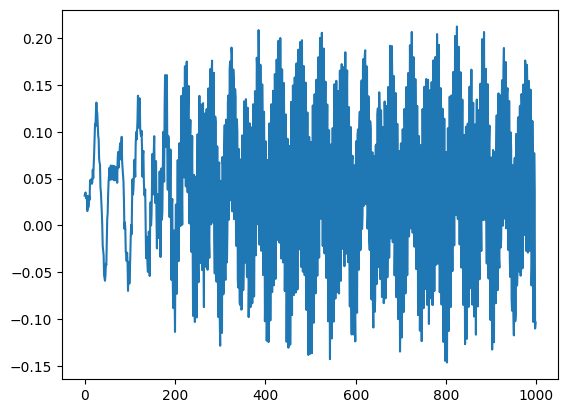

In [29]:
plt.plot(esn(inputs[:]).detach().cpu().numpy(), label='Prediction')

In [30]:
optimizer_prime = torch.optim.Adam(esn_prime.readout.parameters(), lr=0.05)
losses = esn_prime.Train(inputs, targets, epochs=100, lr=0.05, 
                         print_every=10)

Epoch 0, Loss: 0.09118281304836273
Epoch 10, Loss: 0.022963495925068855
Epoch 20, Loss: 0.004074042197316885
Epoch 30, Loss: 0.0015232778387144208
Epoch 40, Loss: 0.0008950572228059173
Epoch 50, Loss: 0.00038731229142285883
Epoch 60, Loss: 0.00021285796537995338
Epoch 70, Loss: 0.00015776923100929707
Epoch 80, Loss: 0.0001408418029313907
Epoch 90, Loss: 0.00012259533104952425
Epoch 99, Loss: 0.00011112751963082701


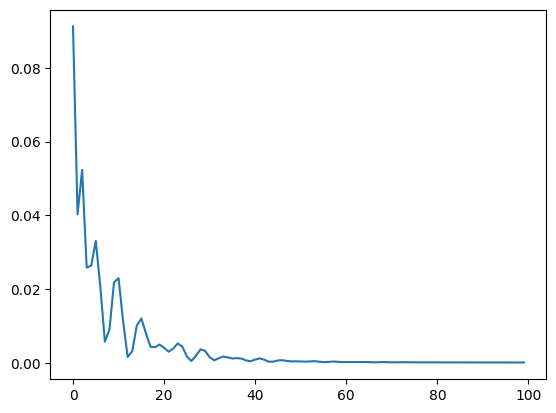

In [31]:
plt.plot(losses.cpu().detach().numpy())

In [32]:
Reservoir_states = esn.res_states()
Readout = esn.readout_layer()
Reservoir_state = esn.res_state()
reservoir_W = esn.res_w()
W_in = esn.w_in()
Reservoir_states.size(), Reservoir_state.size(), Readout

(torch.Size([999, 200]),
 torch.Size([200]),
 Linear(in_features=200, out_features=1, bias=True))

In [33]:
r_states_last = Reservoir_states[-1]
preds = inputs[-1]
preds

tensor([0.1146])

In [34]:
r_states_last = torch.tanh(torch.matmul(reservoir_W, r_states_last)
                  + torch.matmul(W_in, inputs[-1]))

pred = esn.readout(r_states_last)
preds = torch.cat((preds, pred), dim=0)

In [35]:
#TODO
# 1. Prediction method should update the reservoir states. 
# 2. Add prediction loop to get x number of prediction.

In [36]:
preds

tensor([0.1146, 0.0765], grad_fn=<CatBackward0>)